# 📊 STEP4 — Comparaison Interactive des Modèles (Version Optimisée)

Ce notebook compare tous les modèles de STEP3 (Classification, Clustering, Régression) avec des **optimisations** et des **widgets interactifs**.

---

## 1. Installation et Imports

In [66]:
# Installation des dépendances
%pip install ipywidgets scikit-learn pandas numpy matplotlib seaborn xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Clustering (Same as STEP3: KMeans, DBSCAN, SpectralClustering)
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score

# Regression (Same as STEP3: RandomForest, XGBoost, LinearRegression)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Style pour les widgets
style = '<style>.widget-label { font-weight: bold; font-size: 14px; } .widget-dropdown select { font-size: 13px; }</style>'
display(HTML(style))

print("✅ Imports réussis!")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Imports réussis!


---
## 2. Chargement des Données

In [67]:
df = pd.read_csv('../STEP1_PRETREATMENT/DISASTERS_CLEANED.csv')
print(f"📊 Données chargées: {df.shape[0]} lignes, {df.shape[1]} colonnes")
df.head()

📊 Données chargées: 15818 lignes, 23 colonnes


,Year,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,Region,Continent,Latitude,Longitude,...,No Affected,No Homeless,Total Affected,Total Damages ('000 US$),Insured Damages ('000 US$),Start_Date,End_Date,Duration_Days,Month,Season
0,1902,0,0,0,0,0,0,0,14.000,-91.00,...,0.0,0.0,0.0,25000.0,0.0,1902-04-18,1902-04-18,0.0,4.0,0
1,1902,0,0,1,1,0,0,0,14.400,-90.22,...,0.0,0.0,0.0,0.0,0.0,1902-04-08,1902-04-08,0.0,4.0,0
2,1902,0,0,1,1,0,0,0,14.400,-90.22,...,0.0,0.0,0.0,0.0,0.0,1902-10-24,1902-10-24,0.0,10.0,1
3,1903,0,0,2,2,1,1,0,50.358,-81.96,...,0.0,0.0,23.0,0.0,0.0,1903-04-29,1903-04-29,0.0,4.0,0
4,1904,0,1,3,3,2,2,1,22.587,91.13,...,0.0,0.0,0.0,0.0,0.0,1904-11-01,1904-11-01,0.0,11.0,1


---
## 3. Préparation des Données

In [68]:
# ========== CLASSIFICATION ==========
features_clf = ['Country', 'Region', 'Continent', 'Season', 'Month', 
                'Duration_Days', 'Latitude', 'Longitude', 'Disaster Group', 'Dis Mag Value']
target_clf = 'Disaster Type'

# Filtrer les classes rares
class_counts = df[target_clf].value_counts()
valid_classes = class_counts[class_counts >= 5].index
df_clf = df[df[target_clf].isin(valid_classes)].copy()

X_clf = df_clf[features_clf].fillna(0)
y_clf = df_clf[target_clf]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print(f"✅ Classification: {len(X_train_clf)} train, {len(X_test_clf)} test, {len(valid_classes)} classes")

# ========== CLUSTERING ==========
features_clust = ['Latitude', 'Longitude', 'Duration_Days', 'Total Deaths', 'Total Affected', 'Dis Mag Value']
df_clust = df.dropna(subset=features_clust).copy()

for col in ['Duration_Days', 'Total Deaths', 'Total Affected']:
    Q1, Q3 = df_clust[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    df_clust = df_clust[(df_clust[col] >= Q1 - 1.5*IQR) & (df_clust[col] <= Q3 + 1.5*IQR)]

X_clust = df_clust[features_clust]
scaler_clust = StandardScaler()
X_clust_scaled = scaler_clust.fit_transform(X_clust)

if len(X_clust_scaled) > 5000:
    sample_idx = np.random.choice(len(X_clust_scaled), 5000, replace=False)
    X_clust_scaled = X_clust_scaled[sample_idx]

print(f"✅ Clustering: {len(X_clust_scaled)} échantillons")

# ========== RÉGRESSION ==========
features_reg = ['Year', 'Disaster Type', 'Country', 'Region', 'Continent', 
                'Duration_Days', 'Latitude', 'Longitude', 'Dis Mag Value', 'Total Affected']
target_reg = 'Total Deaths'

df_reg = df[df['Total Deaths'] > 0].copy()
Q1, Q3 = df_reg['Total Deaths'].quantile([0.25, 0.75])
IQR = Q3 - Q1
df_reg = df_reg[(df_reg['Total Deaths'] >= Q1 - 1.5*IQR) & (df_reg['Total Deaths'] <= Q3 + 1.5*IQR)]

X_reg = df_reg[features_reg].fillna(0)
y_reg = np.log1p(df_reg[target_reg])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print(f"✅ Régression: {len(X_train_reg)} train, {len(X_test_reg)} test")

✅ Classification: 12650 train, 3163 test, 11 classes
✅ Clustering: 5000 échantillons
✅ Régression: 7784 train, 1947 test


---
## 4. Entraînement des Modèles

In [69]:
# ========== CLASSIFICATION MODELS ==========
clf_models = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7, weights='distance'),
    'Support Vector Machine': SVC(kernel='rbf', C=10, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=15, min_samples_split=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Neural Network (MLP)': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
}

clf_results = {}
print("⏳ Entraînement Classification...")
for name, model in clf_models.items():
    model.fit(X_train_clf_scaled, y_train_clf)
    y_pred = model.predict(X_test_clf_scaled)
    clf_results[name] = {
        'model': model, 'y_pred': y_pred,
        'accuracy': accuracy_score(y_test_clf, y_pred),
        'precision': precision_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_test_clf, y_pred, average='weighted', zero_division=0)
    }
    print(f"   ✓ {name}: {clf_results[name]['accuracy']:.2%}")

# ========== CLUSTERING MODELS (Same as STEP3: KMeans, DBSCAN, Spectral) ==========
print("\n⏳ Entraînement Clustering...")

# Elbow method pour k optimal
silhouettes = [silhouette_score(X_clust_scaled, KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_clust_scaled)) for k in range(2, 11)]
optimal_k = range(2, 11)[np.argmax(silhouettes)]

clust_results = {}

# KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_clust_scaled)
clust_results['KMeans'] = {'n_clusters': optimal_k, 'silhouette': silhouette_score(X_clust_scaled, labels_km), 'labels': labels_km}

# DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=10)
labels_db = dbscan.fit_predict(X_clust_scaled)
n_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
sil_db = silhouette_score(X_clust_scaled, labels_db) if n_db > 1 else 0
clust_results['DBSCAN'] = {'n_clusters': n_db, 'silhouette': sil_db, 'labels': labels_db}

# Spectral Clustering (Same as STEP3)
# Use smaller sample for Spectral Clustering due to memory constraints
X_spectral = X_clust_scaled[:2000] if len(X_clust_scaled) > 2000 else X_clust_scaled
spectral = SpectralClustering(n_clusters=optimal_k, affinity='nearest_neighbors', random_state=42, n_neighbors=10)
labels_spec = spectral.fit_predict(X_spectral)
sil_spec = silhouette_score(X_spectral, labels_spec)
clust_results['Spectral Clustering'] = {'n_clusters': optimal_k, 'silhouette': sil_spec, 'labels': labels_spec}

for name, res in clust_results.items():
    print(f"   ✓ {name}: {res['n_clusters']} clusters, Silhouette: {res['silhouette']:.4f}")

# ========== REGRESSION MODELS (Same as STEP3: RandomForest, XGBoost, LinearRegression) ==========
reg_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42, objective='reg:squarederror')
}

reg_results = {}
print("\n⏳ Entraînement Régression...")
for name, model in reg_models.items():
    model.fit(X_train_reg_scaled, y_train_reg)
    y_pred_log = model.predict(X_test_reg_scaled)
    r2 = r2_score(y_test_reg, y_pred_log)
    y_pred_orig = np.expm1(y_pred_log)
    y_test_orig = np.expm1(y_test_reg)
    reg_results[name] = {
        'model': model, 'r2': r2,
        'rmse': np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),
        'mae': mean_absolute_error(y_test_orig, y_pred_orig)
    }
    print(f"   ✓ {name}: R² = {r2:.4f}")

print("\n✅ Tous les modèles sont entraînés!")

⏳ Entraînement Classification...
   ✓ K-Nearest Neighbors: 57.48%
   ✓ Support Vector Machine: 54.95%
   ✓ Decision Tree: 66.14%
   ✓ Random Forest: 68.86%
   ✓ Gradient Boosting: 69.55%
   ✓ Neural Network (MLP): 60.64%

⏳ Entraînement Clustering...
   ✓ KMeans: 3 clusters, Silhouette: 0.4018
   ✓ DBSCAN: 3 clusters, Silhouette: 0.1026
   ✓ Spectral Clustering: 3 clusters, Silhouette: 0.2116

⏳ Entraînement Régression...
   ✓ Linear Regression: R² = -0.5677
   ✓ Random Forest: R² = 0.3751
   ✓ XGBoost: R² = 0.3847

✅ Tous les modèles sont entraînés!


---
## 5. 🎛️ Interface Interactive — Classification

In [70]:
# ========== CLASSIFICATION WIDGETS WITH HYPERPARAMETERS ==========

# Widgets pour les hyperparamètres
clf_params_widgets = {
    'K-Nearest Neighbors': {
        'n_neighbors': widgets.IntSlider(value=7, min=1, max=30, description='Voisins (k):'),
        'weights': widgets.Dropdown(options=['uniform', 'distance'], value='distance', description='Poids:')
    },
    'Support Vector Machine': {
        'C': widgets.FloatLogSlider(value=10, base=10, min=-1, max=2, step=0.1, description='C:'),
        'kernel': widgets.Dropdown(options=['linear', 'poly', 'rbf', 'sigmoid'], value='rbf', description='Noyau:')
    },
    'Decision Tree': {
        'max_depth': widgets.IntSlider(value=15, min=1, max=50, description='Profondeur:')
    },
    'Random Forest': {
        'n_estimators': widgets.IntSlider(value=200, min=10, max=500, step=10, description='Estimateurs:'),
        'max_depth': widgets.IntSlider(value=20, min=1, max=50, description='Profondeur:')
    },
    'Gradient Boosting': {
        'n_estimators': widgets.IntSlider(value=100, min=10, max=300, step=10, description='Estimateurs:'),
        'max_depth': widgets.IntSlider(value=5, min=1, max=20, description='Profondeur:')
    },
    'Neural Network (MLP)': {
        'hidden_layer_sizes': widgets.Dropdown(options=['(64,)', '(128,)', '(128, 64)', '(64, 32)'], value='(128, 64)', description='Architecture:'),
        'max_iter': widgets.IntSlider(value=500, min=100, max=1000, step=100, description='Max Iter:')
    }
}

clf_dropdown = widgets.Dropdown(
    options=list(clf_results.keys()),
    value='Random Forest',
    description='📊 Modèle:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='350px')
)

clf_btn = widgets.Button(
    description='🚀 Entraîner & Mettre à jour',
    button_style='success',
    layout=widgets.Layout(width='350px', margin='10px 0')
)

clf_output = widgets.Output()
clf_params_box = widgets.VBox([])

def update_clf_ui(change):
    model_name = clf_dropdown.value
    params = clf_params_widgets[model_name]
    clf_params_box.children = list(params.values())

clf_dropdown.observe(update_clf_ui, names='value')

def train_and_update_clf(b):
    with clf_output:
        clear_output(wait=True)
        model_name = clf_dropdown.value
        print(f"⏳ Ré-entraînement de {model_name}...")
        
        # Récupérer les paramètres
        w_params = clf_params_widgets[model_name]
        params = {k: v.value for k, v in w_params.items()}
        
        # Ajustement pour MLP (convertir string tuple en tuple réel)
        if model_name == 'Neural Network (MLP)':
            params['hidden_layer_sizes'] = eval(params['hidden_layer_sizes'])

        # Création et entraînement
        if model_name == 'K-Nearest Neighbors':
            new_model = KNeighborsClassifier(**params)
        elif model_name == 'Support Vector Machine':
            new_model = SVC(**params, random_state=42)
        elif model_name == 'Decision Tree':
            new_model = DecisionTreeClassifier(**params, random_state=42)
        elif model_name == 'Random Forest':
            new_model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
        elif model_name == 'Gradient Boosting':
            new_model = GradientBoostingClassifier(**params, random_state=42)
        elif model_name == 'Neural Network (MLP)':
            new_model = MLPClassifier(**params, random_state=42)

        new_model.fit(X_train_clf_scaled, y_train_clf)
        y_pred = new_model.predict(X_test_clf_scaled)
        
        # Mettre à jour les résultats globaux
        clf_results[model_name] = {
            'model': new_model, 'y_pred': y_pred,
            'accuracy': accuracy_score(y_test_clf, y_pred),
            'precision': precision_score(y_test_clf, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_test_clf, y_pred, average='weighted', zero_division=0),
            'f1': f1_score(y_test_clf, y_pred, average='weighted', zero_division=0)
        }

        # Affichage
        res = clf_results[model_name]
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Métriques
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        values = [res['accuracy'], res['precision'], res['recall'], res['f1']]
        colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6']
        bars = axes[0].bar(metrics, values, color=colors, edgecolor='white', linewidth=2)
        axes[0].set_ylim(0, 1)
        axes[0].set_ylabel('Score', fontsize=12)
        axes[0].set_title(f'📊 Métriques — {model_name}', fontsize=14, fontweight='bold')
        for bar, val in zip(bars, values):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                        f'{val:.2%}', ha='center', fontsize=11, fontweight='bold')
        axes[0].grid(axis='y', alpha=0.3)
        
        # Comparaison
        names = list(clf_results.keys())
        accs = [clf_results[n]['accuracy'] for n in names]
        colors2 = ['#2ecc71' if n == model_name else '#95a5a6' for n in names]
        axes[1].barh(names, accs, color=colors2, edgecolor='white', linewidth=2)
        axes[1].set_xlim(0, 1)
        axes[1].set_xlabel('Accuracy', fontsize=12)
        axes[1].set_title('🏆 Comparaison des Modèles', fontsize=14, fontweight='bold')
        for i, v in enumerate(accs):
            axes[1].text(v + 0.01, i, f'{v:.2%}', va='center', fontsize=10)
        axes[1].grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        print(f"✅ {model_name} mis à jour avec succès!")

clf_btn.on_click(train_and_update_clf)

# Interface
clf_title = widgets.HTML('<h3 style="color:#2c3e50; margin-bottom:10px;">🎯 Explorateur de Classification</h3>')
clf_ui = widgets.VBox([clf_title, clf_dropdown, clf_params_box, clf_btn, clf_output], 
                       layout=widgets.Layout(padding='20px', border='2px solid #3498db', border_radius='10px'))
display(clf_ui)
update_clf_ui(None) # Initialiser les paramètres
train_and_update_clf(None) # Afficher les résultats initiaux


---
## 6. 🎛️ Interface Interactive — Clustering

In [71]:
# ========== CLUSTERING WIDGETS WITH HYPERPARAMETERS ==========

# Widgets pour les hyperparamètres de Clustering
clust_params_widgets = {
    'KMeans': {
        'n_clusters': widgets.IntSlider(value=optimal_k, min=2, max=10, description='Clusters (k):'),
        'n_init': widgets.IntSlider(value=10, min=1, max=20, description='Initialisations:')
    },
    'DBSCAN': {
        'eps': widgets.FloatSlider(value=0.8, min=0.1, max=2.0, step=0.1, description='Epsilon:'),
        'min_samples': widgets.IntSlider(value=10, min=2, max=50, description='Min Samples:')
    },
    'Spectral Clustering': {
        'n_clusters': widgets.IntSlider(value=optimal_k, min=2, max=10, description='Clusters (k):'),
        'n_neighbors': widgets.IntSlider(value=10, min=2, max=50, description='Voisins:')
    }
}

clust_dropdown = widgets.Dropdown(
    options=list(clust_results.keys()),
    value='KMeans',
    description='🎯 Méthode:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='300px')
)

clust_btn = widgets.Button(
    description='🚀 Exécuter Clustering',
    button_style='success',
    layout=widgets.Layout(width='300px', margin='10px 0')
)

clust_output = widgets.Output()
clust_params_box = widgets.VBox([])

def update_clust_ui(change):
    method = clust_dropdown.value
    params = clust_params_widgets[method]
    clust_params_box.children = list(params.values())

clust_dropdown.observe(update_clust_ui, names='value')

def run_clustering(b):
    with clust_output:
        clear_output(wait=True)
        method = clust_dropdown.value
        print(f"⏳ Exécution de {method}...")
        
        w_params = clust_params_widgets[method]
        params = {k: v.value for k, v in w_params.items()}
        
        if method == 'KMeans':
            model = KMeans(**params, random_state=42)
            labels = model.fit_predict(X_clust_scaled)
            n_clusters = params['n_clusters']
            sil = silhouette_score(X_clust_scaled, labels)
            data_to_plot = X_clust_scaled
        elif method == 'DBSCAN':
            model = DBSCAN(**params)
            labels = model.fit_predict(X_clust_scaled)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            sil = silhouette_score(X_clust_scaled, labels) if n_clusters > 1 else 0
            data_to_plot = X_clust_scaled
        elif method == 'Spectral Clustering':
            # Use same sampling logic as before
            X_spectral_local = X_clust_scaled[:2000] if len(X_clust_scaled) > 2000 else X_clust_scaled
            model = SpectralClustering(**params, affinity='nearest_neighbors', random_state=42)
            labels = model.fit_predict(X_spectral_local)
            n_clusters = params['n_clusters']
            sil = silhouette_score(X_spectral_local, labels)
            data_to_plot = X_spectral_local
            
        # Mettre à jour les résultats
        clust_results[method] = {
            'n_clusters': n_clusters,
            'silhouette': sil,
            'labels': labels
        }
        
        # Affichage
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Scatter plot
        scatter = axes[0].scatter(data_to_plot[:, 0], data_to_plot[:, 1], 
                                  c=labels, cmap='viridis', alpha=0.6, s=20)
        axes[0].set_xlabel('Latitude (scaled)', fontsize=11)
        axes[0].set_ylabel('Longitude (scaled)', fontsize=11)
        axes[0].set_title(f'🗺️ {method} — {n_clusters} Clusters', fontsize=14, fontweight='bold')
        plt.colorbar(scatter, ax=axes[0], label='Cluster')
        
        # Comparaison Silhouette
        methods = list(clust_results.keys())
        scores = [clust_results[m]['silhouette'] for m in methods]
        colors = ['#2ecc71' if m == method else '#e74c3c' for m in methods]
        bars = axes[1].bar(methods, scores, color=colors, edgecolor='white', linewidth=2)
        axes[1].set_ylabel('Silhouette Score', fontsize=11)
        axes[1].set_title('📈 Comparaison Silhouette', fontsize=14, fontweight='bold')
        axes[1].set_ylim(0, max(scores) * 1.3 if max(scores) > 0 else 1)
        for bar, val in zip(bars, scores):
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
        plt.xticks(rotation=15)
        
        plt.tight_layout()
        plt.show()
        if sil == 0 and method == 'DBSCAN':
             print("⚠️ DBSCAN n'a trouvé qu'un seul cluster ou trop de bruit. Ajustez Epsilon ou Min Samples.")

clust_btn.on_click(run_clustering)

# Interface
clust_title = widgets.HTML('<h3 style="color:#27ae60; margin-bottom:10px;">🎯 Explorateur de Clustering</h3>')
clust_ui = widgets.VBox([clust_title, clust_dropdown, clust_params_box, clust_btn, clust_output],
                         layout=widgets.Layout(padding='20px', border='2px solid #27ae60', border_radius='10px'))
display(clust_ui)
update_clust_ui(None)
run_clustering(None)


---
## 7. 🎛️ Interface Interactive — Régression

In [72]:
# ========== REGRESSION WIDGETS WITH HYPERPARAMETERS ==========

# Widgets pour les hyperparamètres de Régression
reg_params_widgets = {
    'Linear Regression': {
        'fit_intercept': widgets.Checkbox(value=True, description='Fit Intercept:')
    },
    'Random Forest': {
        'n_estimators': widgets.IntSlider(value=200, min=10, max=500, step=10, description='Estimateurs:'),
        'max_depth': widgets.IntSlider(value=15, min=1, max=30, description='Profondeur:')
    },
    'XGBoost': {
        'n_estimators': widgets.IntSlider(value=200, min=10, max=500, step=10, description='Estimateurs:'),
        'max_depth': widgets.IntSlider(value=5, min=1, max=20, description='Profondeur:'),
        'learning_rate': widgets.FloatSlider(value=0.05, min=0.01, max=0.3, step=0.01, description='LR:')
    }
}

reg_dropdown = widgets.Dropdown(
    options=list(reg_results.keys()),
    value='XGBoost',
    description='📈 Modèle:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='300px')
)

reg_btn = widgets.Button(
    description='🚀 Entraîner & Analyser',
    button_style='success',
    layout=widgets.Layout(width='300px', margin='10px 0')
)

reg_output = widgets.Output()
reg_params_box = widgets.VBox([])

def update_reg_ui(change):
    model_name = reg_dropdown.value
    params = reg_params_widgets[model_name]
    reg_params_box.children = list(params.values())

reg_dropdown.observe(update_reg_ui, names='value')

def train_and_update_reg(b):
    with reg_output:
        clear_output(wait=True)
        model_name = reg_dropdown.value
        print(f"⏳ Entraînement de {model_name}...")
        
        # Récupérer les paramètres
        w_params = reg_params_widgets[model_name]
        params = {k: v.value for k, v in w_params.items()}
        
        # Création et entraînement
        if model_name == 'Linear Regression':
            new_model = LinearRegression(**params)
        elif model_name == 'Random Forest':
            new_model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        elif model_name == 'XGBoost':
            new_model = xgb.XGBRegressor(**params, random_state=42, objective='reg:squarederror')

        new_model.fit(X_train_reg_scaled, y_train_reg)
        y_pred_log = new_model.predict(X_test_reg_scaled)
        
        # Métriques
        r2 = r2_score(y_test_reg, y_pred_log)
        y_pred_orig = np.expm1(y_pred_log)
        y_test_orig = np.expm1(y_test_reg)
        
        # Mettre à jour les résultats
        reg_results[model_name] = {
            'model': new_model, 
            'r2': r2,
            'rmse': np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),
            'mae': mean_absolute_error(y_test_orig, y_pred_orig)
        }
        
        # Affichage
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        res = reg_results[model_name]
        
        # Métriques
        metrics = ['R² Score', 'RMSE', 'MAE']
        v_r2 = res['r2']
        v_rmse = res['rmse']
        v_mae = res['mae']
        
        # Normalisation arbitraire pour le graphique
        values = [v_r2, v_rmse/100, v_mae/10]  
        colors = ['#3498db', '#e74c3c', '#f39c12']
        bars = axes[0].bar(metrics, values, color=colors, edgecolor='white', linewidth=2)
        axes[0].set_ylabel('Score (normalisé)', fontsize=11)
        axes[0].set_title(f'📈 Métriques — {model_name}', fontsize=14, fontweight='bold')
        labels = [f'{v_r2:.4f}', f'{v_rmse:.2f}', f'{v_mae:.2f}']
        for bar, lbl in zip(bars, labels):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        lbl, ha='center', fontsize=11, fontweight='bold')
        axes[0].grid(axis='y', alpha=0.3)
        
        # Comparaison R²
        names = list(reg_results.keys())
        r2s = [reg_results[n]['r2'] for n in names]
        colors2 = ['#2ecc71' if n == model_name else '#9b59b6' for n in names]
        bars2 = axes[1].bar(names, r2s, color=colors2, edgecolor='white', linewidth=2)
        axes[1].set_ylabel('R² Score', fontsize=11)
        axes[1].set_title('🏆 Comparaison R²', fontsize=14, fontweight='bold')
        for bar, val in zip(bars2, r2s):
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        print(f"✅ {model_name} mis à jour avec succès!")

reg_btn.on_click(train_and_update_reg)

# Interface
reg_title = widgets.HTML('<h3 style="color:#9b59b6; margin-bottom:10px;">📈 Explorateur de Régression</h3>')
reg_ui = widgets.VBox([reg_title, reg_dropdown, reg_params_box, reg_btn, reg_output],
                       layout=widgets.Layout(padding='20px', border='2px solid #9b59b6', border_radius='10px'))
display(reg_ui)
update_reg_ui(None)
train_and_update_reg(None)


---
## 8. 🏆 Dashboard Final — Comparaison Globale

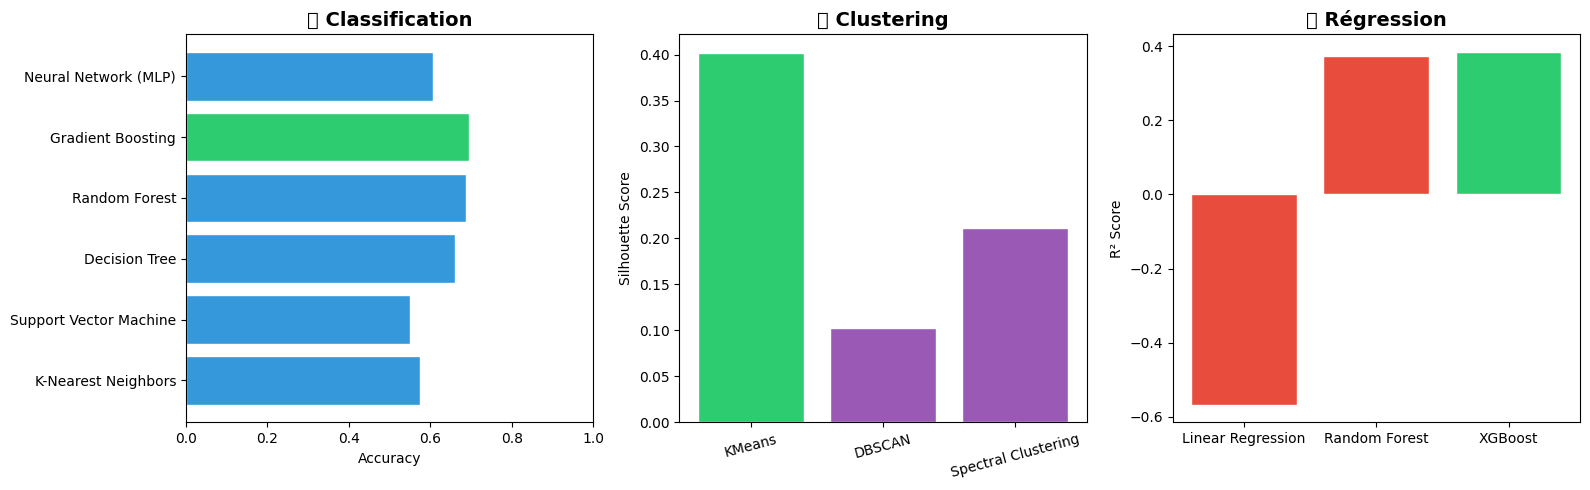


✅ Analyse terminée!


In [73]:
# Trouver les meilleurs modèles
best_clf = max(clf_results.keys(), key=lambda m: clf_results[m]['accuracy'])
best_clust = max(clust_results.keys(), key=lambda m: clust_results[m]['silhouette'])
best_reg = max(reg_results.keys(), key=lambda m: reg_results[m]['r2'])

# Dashboard HTML stylé
dashboard_html = f'''
<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 15px; color: white;">
    <h2 style="text-align: center; margin-bottom: 25px;">🏆 Résumé des Meilleurs Modèles</h2>
    
    <div style="display: flex; justify-content: space-around; flex-wrap: wrap;">
        <div style="background: rgba(255,255,255,0.2); padding: 20px; border-radius: 10px; margin: 10px; min-width: 250px;">
            <h3 style="margin: 0 0 10px 0;">📊 Classification</h3>
            <p style="font-size: 18px; margin: 5px 0;"><strong>{best_clf}</strong></p>
            <p style="font-size: 24px; margin: 0;">Accuracy: {clf_results[best_clf]['accuracy']:.2%}</p>
        </div>
        
        <div style="background: rgba(255,255,255,0.2); padding: 20px; border-radius: 10px; margin: 10px; min-width: 250px;">
            <h3 style="margin: 0 0 10px 0;">🎯 Clustering</h3>
            <p style="font-size: 18px; margin: 5px 0;"><strong>{best_clust}</strong></p>
            <p style="font-size: 24px; margin: 0;">Silhouette: {clust_results[best_clust]['silhouette']:.4f}</p>
        </div>
        
        <div style="background: rgba(255,255,255,0.2); padding: 20px; border-radius: 10px; margin: 10px; min-width: 250px;">
            <h3 style="margin: 0 0 10px 0;">📈 Régression</h3>
            <p style="font-size: 18px; margin: 5px 0;"><strong>{best_reg}</strong></p>
            <p style="font-size: 24px; margin: 0;">R² Score: {reg_results[best_reg]['r2']:.4f}</p>
        </div>
    </div>
</div>
'''

display(HTML(dashboard_html))

# Graphique final
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Classification
clf_names = list(clf_results.keys())
clf_accs = [clf_results[n]['accuracy'] for n in clf_names]
colors_clf = ['#2ecc71' if n == best_clf else '#3498db' for n in clf_names]
axes[0].barh(clf_names, clf_accs, color=colors_clf, edgecolor='white')
axes[0].set_xlim(0, 1)
axes[0].set_title('📊 Classification', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Accuracy')

# Clustering  
clust_names = list(clust_results.keys())
clust_scores = [clust_results[n]['silhouette'] for n in clust_names]
colors_clust = ['#2ecc71' if n == best_clust else '#9b59b6' for n in clust_names]
axes[1].bar(clust_names, clust_scores, color=colors_clust, edgecolor='white')
axes[1].set_title('🎯 Clustering', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Silhouette Score')
plt.sca(axes[1])
plt.xticks(rotation=15)

# Regression
reg_names = list(reg_results.keys())
reg_r2s = [reg_results[n]['r2'] for n in reg_names]
colors_reg = ['#2ecc71' if n == best_reg else '#e74c3c' for n in reg_names]
axes[2].bar(reg_names, reg_r2s, color=colors_reg, edgecolor='white')
axes[2].set_title('📈 Régression', fontsize=14, fontweight='bold')
axes[2].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

print("\n✅ Analyse terminée!")